In [395]:
import Pkg;
Pkg.add("DifferentialEquations");
Pkg.add("LinearAlgebra");
Pkg.add("ForwardDiff");
Pkg.add("Plots");
Pkg.add("Statistics");
Pkg.add("LaTeXStrings");
Pkg.add("DelimitedFiles");

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.11/Project.toml`
  No Changes to `~/.julia/environments/v1.11/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.11/Project.toml`
  No Changes to `~/.julia/environments/v1.11/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.11/Project.toml`
  No Changes to `~/.julia/environments/v1.11/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.11/Project.toml`
  No Changes to `~/.julia/environments/v1.11/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.11/Project.toml`
  No Changes to `~/.julia/environments/v1.11/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.11/Project.toml`
  No Changes to `~/.julia/environments/v1.11/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.11/Project.to

In [393]:
using DifferentialEquations, LinearAlgebra, ForwardDiff, Plots, Statistics, LaTeXStrings, Base.Threads, DelimitedFiles;
default(framestyle=:box, guidefont=font(14), titlefont=font(14), tickfont=font(12), legend_font=font(12), legend=false, linewidth=3);
Threads.nthreads()

20

In [33]:
Mpl = 2.4e18;
M = 1e16 / Mpl;
phic = sqrt(2)M;
mu2 = 10;

Pi2 = 100;
mu1 = Pi2/M^2/phic;
Lambda = 5.4e15 / Mpl * (10/sqrt(Pi2)) * M * sqrt(phic);
psir = sqrt(Lambda^4 * sqrt(Pi2) / 48 / sqrt(2*π^3));

In [127]:
function V(x,y::Vector) 
    return Lambda^4 * ((1-dot(y,y)/M^2)^2 + 2*x^2*dot(y,y) / M^2 / phic^2 + (x-phic)/mu1 - (x-phic)^2/mu2^2)
end;

function Vx(x,y::Vector)
    Vinx(x) = V(x,y)
    return ForwardDiff.derivative(Vinx,x)
end;

function Vy(x,y::Vector)
    Viny(y) = V(x,y)
    return ForwardDiff.gradient(Viny,y)
end;

function Vr(x,yr)
    return Lambda^4 * ((1-yr^2/M^2)^2 + 2*x^2*yr^2 / M^2 / phic^2 + (x-phic)/mu1 - (x-phic)^2/mu2^2)
end;

function etar(x,yr)
    Vrx(yr) = Vr(x,yr)
    Vp = yr -> ForwardDiff.derivative(Vrx, yr)
    Vpp = ForwardDiff.derivative(Vp, yr)
    return Vpp / Vr(x,yr)
end;

function H(x,px,y::Vector,py::Vector)
    return sqrt((px^2/2 + dot(py,py)/2 + V(x,y))/3)
end;

function drift(du,u,p,t) # u[1] = x, u[2] = px, u[3:2+ny] = y, u[3+ny:2+2ny] = py
    ny = Int((length(u)-2)/2)
    x = u[1]
    px = u[2]
    y = u[3:2+ny]
    py = u[3+ny:2+2ny]
    Hubble = H(x,px,y,py)
    
    du[1] = px/Hubble
    du[2] = -3px-Vx(x,y)/Hubble

    for i in 1:ny
        du[2+i] = py[i]/Hubble
        du[2+ny+i] = -3py[i]-Vy(x,y)[i]/Hubble
    end
end;

function diffusion(du,u,p,t)
    ny = Int((length(u)-2)/2)
    x = u[1]
    px = u[2]
    y = u[3:2+ny]
    py = u[3+ny:2+2ny]
    Hubble = H(x,px,y,py)

    du[1] = Hubble/2/π
    du[2] = 0

    for i in 1:ny
        du[2+i] = Hubble/2/π
        du[2+ny+i] = 0
    end
end;

function SRvio(u,t,integrator)
    ny = Int((length(u)-2)/2)
    x = u[1]
    y = u[3:2+ny]
    yr = sqrt(dot(y,y))
    return etar(x,yr) < -2
end;

## waterfall = 2

In [415]:
ny = 2;
y0 = [psir for i in 1:ny];
py0 = [0 for i in 1:ny];
u0 = [[phic + 15/mu1, 0]; y0; py0];
Nspan = (0,100);
prob = SDEProblem(drift, diffusion, u0, Nspan, 0);

In [417]:
affect!(integrator) = terminate!(integrator)
cb = DiscreteCallback(SRvio, affect!)
@time sol = solve(prob,reltol=1e-10,abstol=1e-10,callback=cb);

  1.354431 seconds (1.90 M allocations: 60.145 MiB, 2.39% gc time, 96.61% compilation time: 100% of which was recompilation)


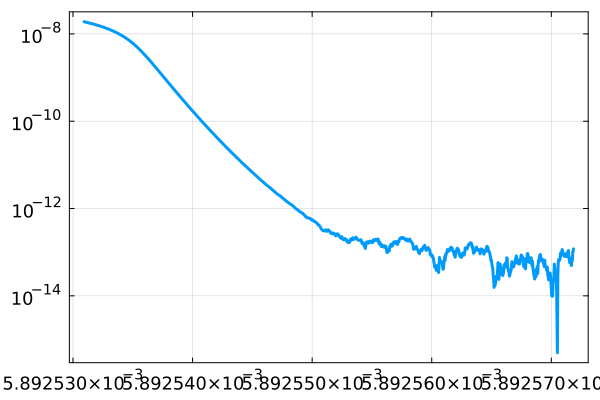

In [419]:
xlist = [u[1] for u in sol.u];
yrlist = [sqrt(dot(u[3:2+ny],u[3:2+ny])) for u in sol.u];
plot(xlist,yrlist,yscale=:log10)

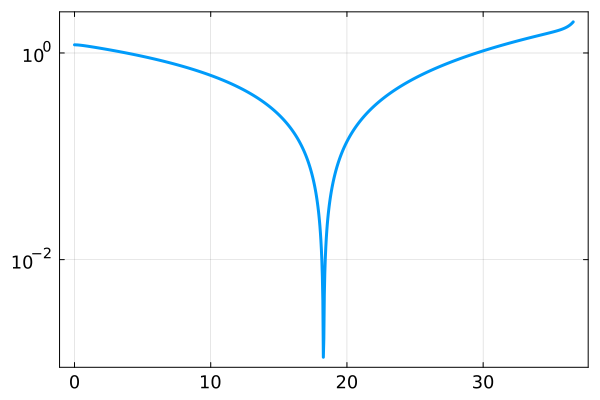

In [421]:
plot(sol.t, map(abs,map(etar,xlist,yrlist)), yscale=:log10)

In [423]:
sol.t[end]

36.613125339124046

In [435]:
sample = 10^6;
dNlist = zeros(sample);
@time Threads.@threads for i in 1:sample
    dNlist[i] = solve(prob,reltol=1e-10,abstol=1e-10,callback=cb,save_everystep=false).t[end]
end;

24564.771714 seconds (990.08 G allocations: 20.405 TiB, 20.70% gc time, 0.00% compilation time)


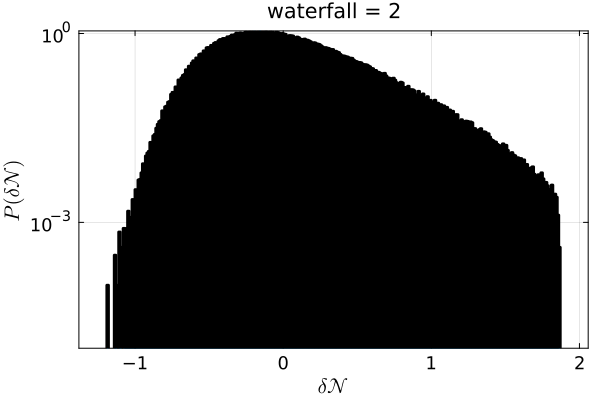

In [436]:
histogram(dNlist .- mean(dNlist), normalize=true, yscale=:log10, xlabel=L"$\delta\mathcal{N}$", ylabel=L"$P(\delta\mathcal{N})$", title="waterfall = 2")

In [437]:
writedlm("N=2.csv",dNlist);

In [428]:
dNlist = vec(readdlm("N=2.csv"));

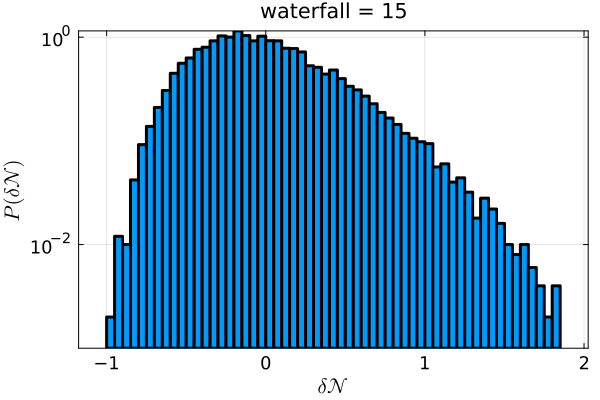

In [429]:
histogram(dNlist .- mean(dNlist), normalize=true, yscale=:log10, xlabel=L"$\delta\mathcal{N}$", ylabel=L"$P(\delta\mathcal{N})$", title="waterfall = 2")

## waterfall = 15

In [441]:
ny = 15;
y0 = [psir for i in 1:ny];
py0 = [0 for i in 1:ny];
u0 = [[phic + 15/mu1, 0]; y0; py0];
Nspan = (0,100);
prob = SDEProblem(drift, diffusion, u0, Nspan, 0);

In [443]:
affect!(integrator) = terminate!(integrator)
cb = DiscreteCallback(SRvio, affect!)
@time sol = solve(prob,reltol=1e-10,abstol=1e-10,callback=cb);

  1.151906 seconds (3.37 M allocations: 193.993 MiB, 4.56% gc time, 80.75% compilation time: 100% of which was recompilation)


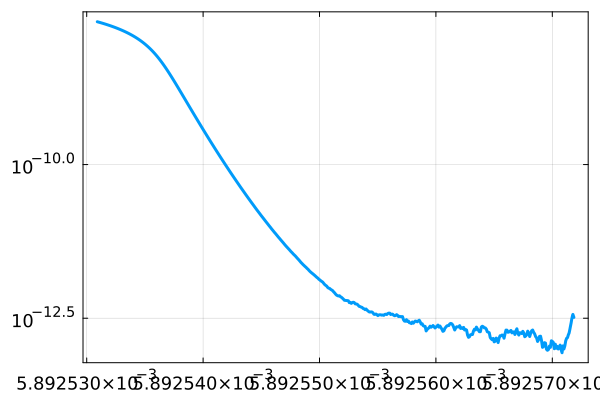

In [445]:
xlist = [u[1] for u in sol.u];
yrlist = [sqrt(dot(u[3:2+ny],u[3:2+ny])) for u in sol.u];
plot(xlist,yrlist,yscale=:log10)

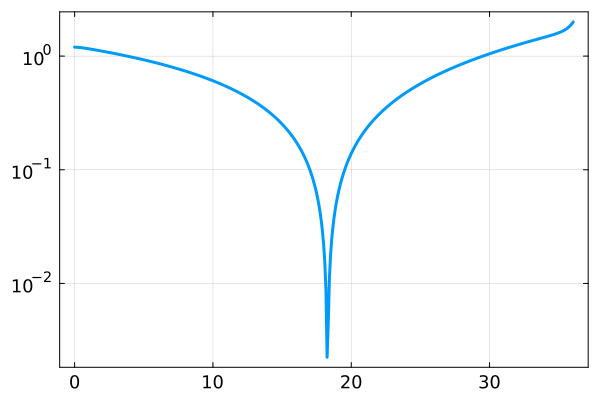

In [447]:
plot(sol.t, map(abs,map(etar,xlist,yrlist)), yscale=:log10)

In [449]:
sol.t[end]

36.05076195564883

In [ ]:
sample = 10^6;
dNlist = zeros(sample);
@time Threads.@threads for i in 1:sample
    dNlist[i] = solve(prob,reltol=1e-10,abstol=1e-10,callback=cb,save_everystep=false).t[end]
end;

In [ ]:
histogram(dNlist .- mean(dNlist), normalize=true, yscale=:log10, xlabel=L"$\delta\mathcal{N}$", ylabel=L"$P(\delta\mathcal{N})$", title="waterfall = 15")

In [ ]:
writedlm("N=15.csv",dNlist);

In [407]:
dNlist = vec(readdlm("N=2.csv"));

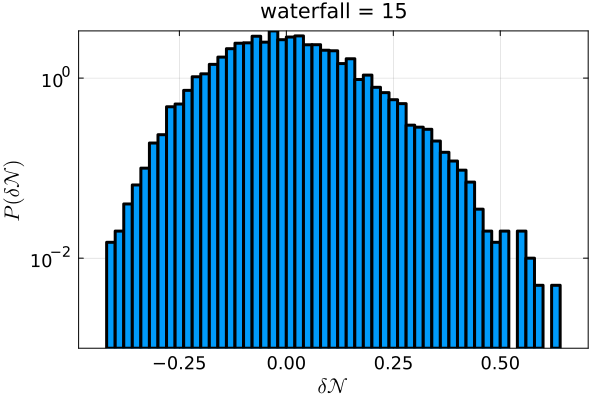

In [411]:
histogram(dNlist .- mean(dNlist), normalize=true, yscale=:log10, xlabel=L"$\delta\mathcal{N}$", ylabel=L"$P(\delta\mathcal{N})$", title="waterfall = 15")